utils.py

In [1]:
import pandas as pd
import math
import numpy as np
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# graphics libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

In [4]:
import datetime as dt

In [5]:
def loadAndCleanData(file):
    dataset = pd.read_csv(file,encoding='utf-8')
    dataset.fillna(value=0,inplace=True)
    # this next line was taken from https://stackoverflow.com/questions/22649693/drop-rows-with-all-zeros-in-pandas-data-frame
    dataset = dataset.loc[(dataset!=0).any(axis=1)] # this lets me drop rows where all values are 0
    return dataset

In [6]:
def computeProbability(feature, bin, data):
    count = 0.0
    for i,datapoint in data.iterrows():
        if datapoint[feature] >= bin[0] and datapoint[feature] < bin[1]:
            count += 1
    return count / len(data)

In [7]:
def computeConfidenceInterval(data):
    npArray = 1.0 * np.array(data)
    stdErr = scipy.stats.sem(npArray)
    n = len(data)
    return stdErr * scipy.stats.t.ppf((1+.95)/2.0,n-1)

In [8]:
def getEffectSize(d1,d2):
    m1 = d1.mean()
    m2 = d2.mean()
    s1 = d1.std()
    s2 = d1.std()
    return (m1 - m2) / math.sqrt((math.pow(s1,3) + math.pow(s2, 3)) / 2.0)

In [9]:
def runTTest(d1,d2):
    return scipy.stats.ttest_ind(d1,d2)

In [10]:
def runANOVA(dataframe,vars):
    model = ols(vars, data=dataframe).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return aov_table

In [11]:
def plotTimeline(data, time_col, val_col):
    sns.lineplot(data=data, x=time_col, y=val_col)
    plt.show()

In [12]:
def plotMultipleTimelines(data, time_col, val_col, cat_col):
    sns.lineplot(data=data, x=time_col, y=val_col, hue=cat_col)
    plt.show()

In [13]:
def runTemporalLinearRegression(data, x, y):
    x_col = data[x].map(dt.datetime.toordinal).values.reshape(-1,1)
    y_col = data[y].values.reshape(-1, 1)
    
    regr = LinearRegression()
    regr.fit(x_col, y_col)
    
    y_hat = regr.predict(x_col)
    fitScore = r2_score(y_col, y_hat)
    print("Linear Regression Fit: " + str(fitScore))
    
    plt.scatter(data[x], y_col, color='lightblue')
    plt.plot(data[x], y_hat, color='red', linewidth=2)
    plt.show()
    
    return [regr.coef_[0][0], regr.intercept_[0]]

In [14]:
def logistic(x, x0, m, b):
    y = 1.0 / (1.0 + np.exp(-m*(x - x0) + b))
    return (y)

In [15]:
def runTemporalLogisticRegression(data, x, y):
    x_col = data[x].map(dt.datatime.toordinal)
    y_col = data[y]
    
    # give the curve a crappy fit to start with
    p0 = [np.medium(x_col), 1, min(y_col)]
    params, pcov = curve_fit(logistic, x_col, y_col, p0)
    
    # show fit
    plt.scatter(data[x], y_col, color='lightblue')
    plt.plot(data[x], logistic(x_col, params[0], params[1], params[2]), color='red', linewidth=2)
    plt.show()
    
    return params

covid.py

In [16]:
def correctDateFormat(df):
    df = df.melt(id_vars=df.columns[0:4], var_name="Date", value_name="Confirmed")
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [17]:
def groupByCountry(df, country):
    data = df.loc[df["Country/Region"] == country]
    return data.groupby("Date", as_index = False).sum()

main.py

In [18]:
df = loadAndCleanData("COVID-19\csse_covid_19_data\csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = correctDateFormat(df)
#print(df.head())
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,0,Afghanistan,33.0000,65.0000,2020-01-22,0
1,0,Albania,41.1533,20.1683,2020-01-22,0
2,0,Algeria,28.0339,1.6596,2020-01-22,0
3,0,Andorra,42.5063,1.5218,2020-01-22,0
4,0,Angola,-11.2027,17.8739,2020-01-22,0


C:\Users\jkibo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


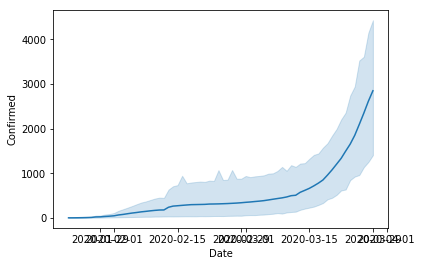

In [19]:
plotTimeline(df, "Date", "Confirmed")

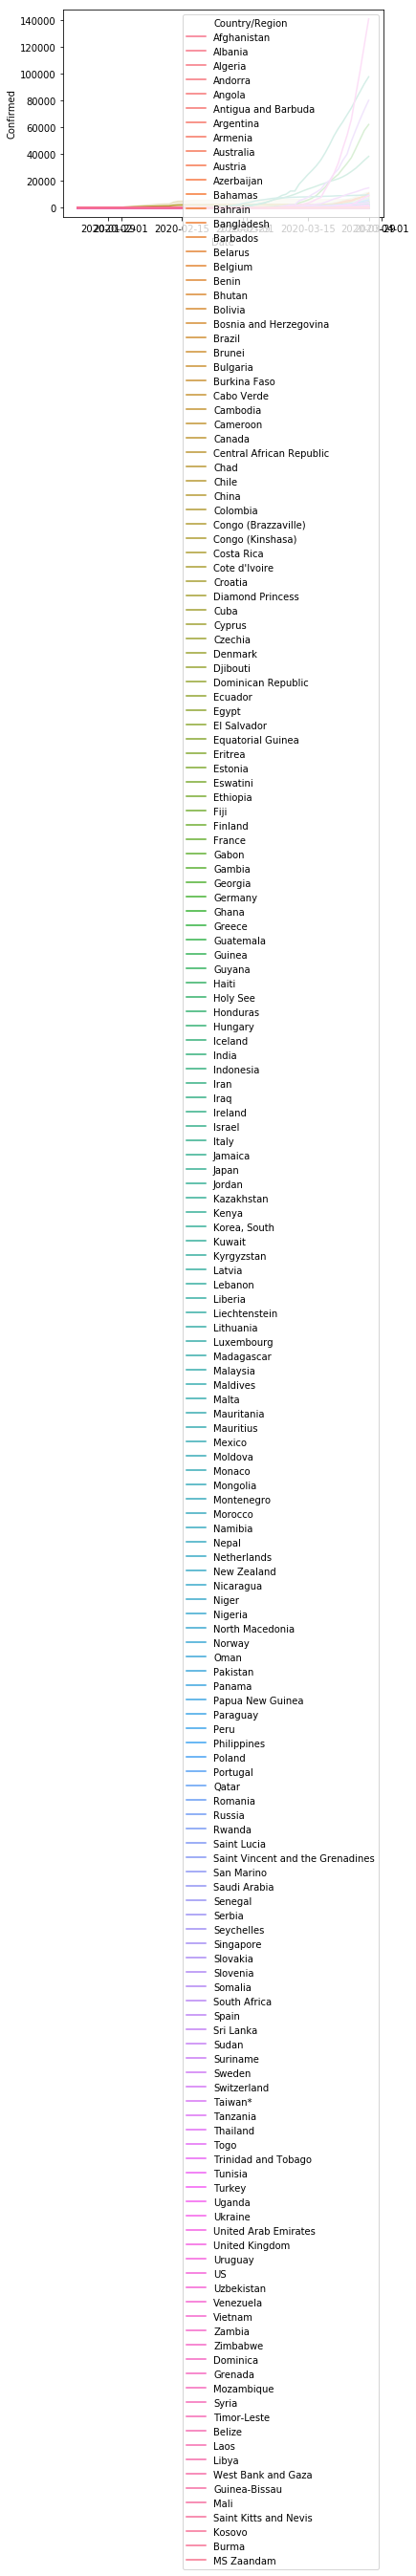

In [20]:
plotMultipleTimelines(df, "Date", "Confirmed", "Country/Region")

In [21]:
x = "Date"
y = "Confirmed"

Linear Regression Fit: 0.011079451853818534


TypeError: invalid type promotion

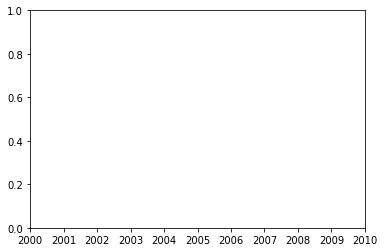

In [22]:
#linear regression on covid data
linearModel = runTemporalLinearRegression(df, x, y)
print("y =",str(linearModel[0])+"x +",linearModel[1])

In [ ]:
# look at sum total cases over entire world
groupedDf = df.groupby(x, as_index=False).sum()
linearModel = runTemporalLinearRegression(groupedDf, x , y)
print("y_world =",str(linearModel[0])+"x +",linearModel[1])